In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, plot_importance

import utils.datasets_utils as datasets_utils
import utils.classification_utils as classification_utils

sns.set_palette("Set2")
sns.set_style("whitegrid")

In [2]:
datasets = datasets_utils.load_datasets()
datasets_wrapper = datasets_utils.DatasetsWrapper(datasets)

In [5]:
datasets_wrapper.get_shapes()

,train_X,val_X,test_X,train_y,val_y,test_y
spectral_original,"(21572, 189)","(2397, 189)","(5993, 189)","(21572,)","(2397,)","(5993,)"
all_original,"(21572, 287)","(2397, 287)","(5993, 287)","(21572,)","(2397,)","(5993,)"
pca_original,"(21572, 138)","(2397, 138)","(5993, 138)","(21572,)","(2397,)","(5993,)"
umap_original,"(21572, 15)","(2397, 15)","(5993, 15)","(21572,)","(2397,)","(5993,)"
spectral_modified,"(23114, 189)","(2397, 189)","(5993, 189)","(23114,)","(2397,)","(5993,)"
all_modified,"(23114, 287)","(2397, 287)","(5993, 287)","(23114,)","(2397,)","(5993,)"
pca_modified,"(23114, 136)","(2397, 136)","(5993, 136)","(23114,)","(2397,)","(5993,)"
umap_modified,"(23114, 15)","(2397, 15)","(5993, 15)","(23114,)","(2397,)","(5993,)"


# 1. Random Forest

## 1.1. Training

Initially we will create a model with the following hyperparemeters in order to decide with which dataset to continue the analysis (what subset of feature more preciesly).
Note that scaling the data is not neccesary when using tree-based methods, since they "look at" the features in isloation, performing axis-aligned splits.

In [6]:
rf_classifiers = [classification_utils.ClassifierFactory.create_instance(
    dataset=dataset, 
    classifier=RandomForestClassifier(criterion='gini', max_depth=50, min_samples_split=20, n_estimators=100, random_state=42, n_jobs=5),
    tree_type_classifier=True
) for dataset in datasets]

In [7]:
rf_cl_collection = classification_utils.ClassifiersCollection(rf_classifiers)

In [8]:
rf_cl_collection.fit_classifiers()

Fitting classifiers...


100%|██████████| 8/8 [03:39<00:00, 27.49s/it]

Done


## 1.2. Initial Results

In [9]:
rf_evaluation_df = rf_cl_collection.evaluate_classifiers()

In [10]:
rf_evaluation_df[[dataset.name for dataset in datasets if 'original' in dataset.name]]

spectral_original                     all_original  \
                                 train       val      test        train   
accuracy                      0.881606  0.599082  0.599199     0.887586   
precision (weighted)          0.892724  0.566843  0.577811     0.892784   
recall (weighted)             0.881606  0.599082  0.599199     0.887586   
f1 (weighted)                 0.868112  0.554506  0.555549     0.874057   

                                         pca_original                      \
                           val      test        train       val      test   
accuracy              0.605757  0.603204     0.884294  0.565290  0.561488   
precision (weighted)  0.575734  0.602059     0.890320  0.551598  0.566772   
recall (weighted)     0.605757  0.603204     0.884294  0.565290  0.561488   
f1 (weighted)         0.560094  0.561054     0.867008  0.501739  0.499720   

                     umap_original                      
                             train       val      test  
accuracy                  0.731782  0.549020  0.542633  
precision (weighted)      0.743452  0.521301  0.518076  
recall (weighted)         0.731782  0.549020  0.542633  
f1 (weighted)             0.712839  0.519616  0.516576

In [11]:
rf_evaluation_df[[dataset.name for dataset in datasets if 'modified' in dataset.name]]

spectral_modified                     all_modified  \
                                 train       val      test        train   
accuracy                      0.942026  0.591573  0.585350     0.950723   
precision (weighted)          0.943226  0.605171  0.604692     0.951564   
recall (weighted)             0.942026  0.591573  0.585350     0.950723   
f1 (weighted)                 0.940482  0.589471  0.584166     0.949294   

                                         pca_modified                      \
                           val      test        train       val      test   
accuracy              0.599499  0.590856     0.960716  0.569045  0.558652   
precision (weighted)  0.618485  0.613877     0.961503  0.576114  0.567217   
recall (weighted)     0.599499  0.590856     0.960716  0.569045  0.558652   
f1 (weighted)         0.596385  0.588157     0.958813  0.555722  0.544990   

                     umap_modified                      
                             train       val      test  
accuracy                  0.777970  0.496037  0.495411  
precision (weighted)      0.780495  0.544510  0.550939  
recall (weighted)         0.777970  0.496037  0.495411  
f1 (weighted)             0.776059  0.505708  0.505554

all_modified seems to have the best results on validation set, therefore we will use this dataset for further fine-tuning

In [12]:
rf_all_modified_classifier = rf_cl_collection.get_classifier('all_modified')

In [13]:
rf_all_modified_classifier.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.950723,0.599499,0.590856
precision (weighted),0.951564,0.618485,0.613877
recall (weighted),0.950723,0.599499,0.590856
f1 (weighted),0.949294,0.596385,0.588157


## 1.3 Hyperparameter tuning

In [15]:
rf_dataset = datasets_wrapper.get_dataset('all_modified')

rf_train_X, rf_train_y = rf_dataset.train.X, rf_dataset.train.y
rf_val_X, rf_val_y = rf_dataset.val.X, rf_dataset.val.y

We will use grid search with the following hyperparameter combinations

In [ ]:
params = dict(n_estimators=[50, 100, 150], max_depth=[15, 25, 30], min_samples_split=[20, 40, 60])

In [16]:
rf_clf = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=5)
skf = StratifiedKFold(5, shuffle=True, random_state=23)
grid_search = GridSearchCV(rf_clf, params, cv=3, n_jobs=-1)
grid_search.fit(pd.concat([rf_train_X, rf_val_X], axis=0), pd.concat([rf_train_y, rf_val_y], axis=0))

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=5, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 25, 30],
                         'min_samples_split': [20, 40, 60],
                         'n_estimators': [50, 100, 150]})

In [17]:
grid_search.best_score_

0.6420375740700154

In [18]:
grid_search.best_params_

{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 150}

In [20]:
rf_final_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=rf_dataset,
    classifier=grid_search.best_estimator_,
    tree_type_classifier=True
)

## 1.4 Final Results

In [22]:
rf_final_classifier.get_clf_evaluation().get_scores(on_sets=['train', 'val', 'test'])

,train,val,test
accuracy,0.951415,0.935336,0.609211
precision (weighted),0.952541,0.931775,0.624481
recall (weighted),0.951415,0.935336,0.609211
f1 (weighted),0.949887,0.929916,0.602074


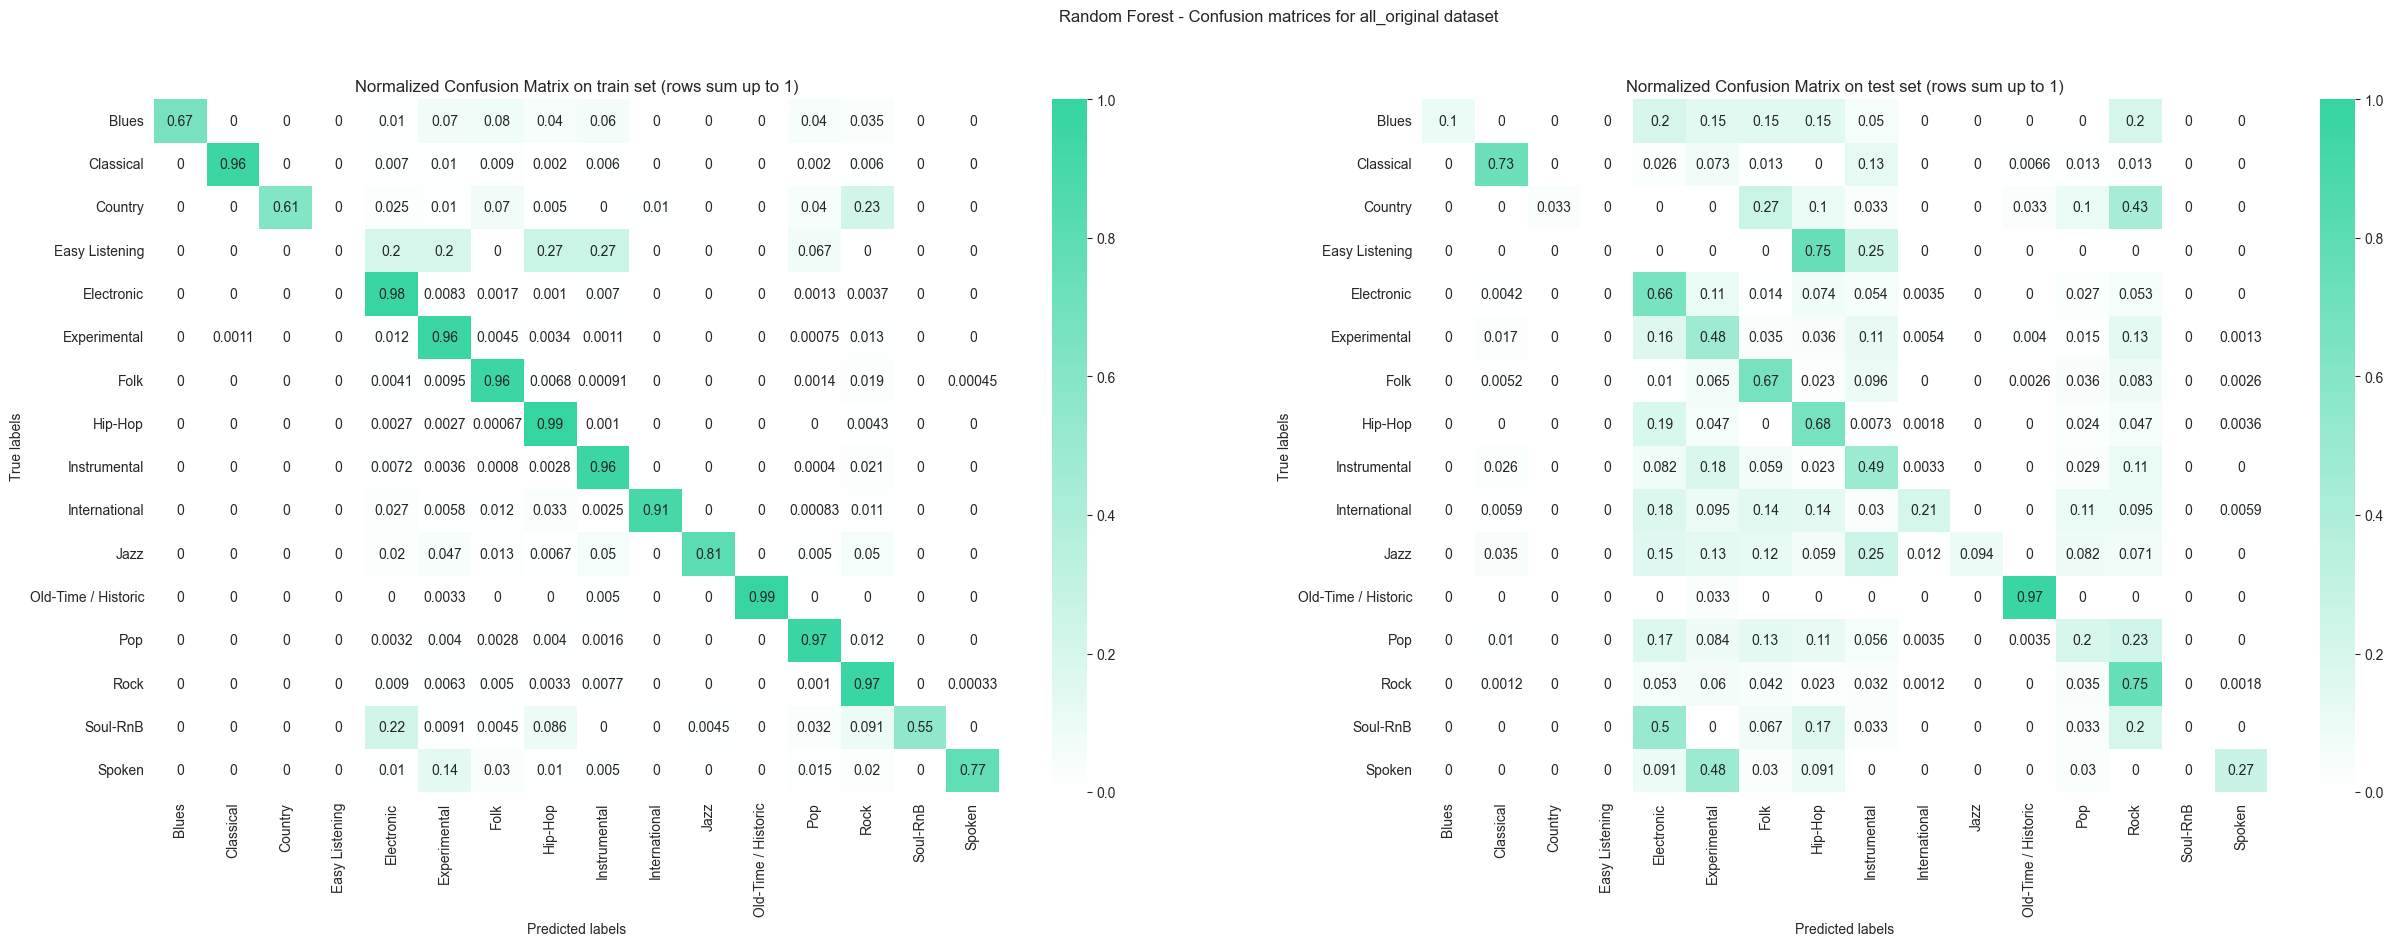

In [28]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
rf_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
rf_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('Random Forest - Confusion matrices for all_original dataset')
plt.show()

We notice that the model performs very well on the train set, and not so well on the test set. From the following plots, we can conclude the following:
- Easy Listening tracks are not recognized by the model even on the train set (likely due to the small nuber of tracks that belong in this genre)
- When a model classifies a track as Jazz, does it with high precision (is certain that the track belongs to the Jazz genre), but fails to recognize most .of the tracks belonging in this category.
- None of the tracks we classified as Soul-RnB on the test set
- Old-Time / Historic tracks seem to be the most discriminative

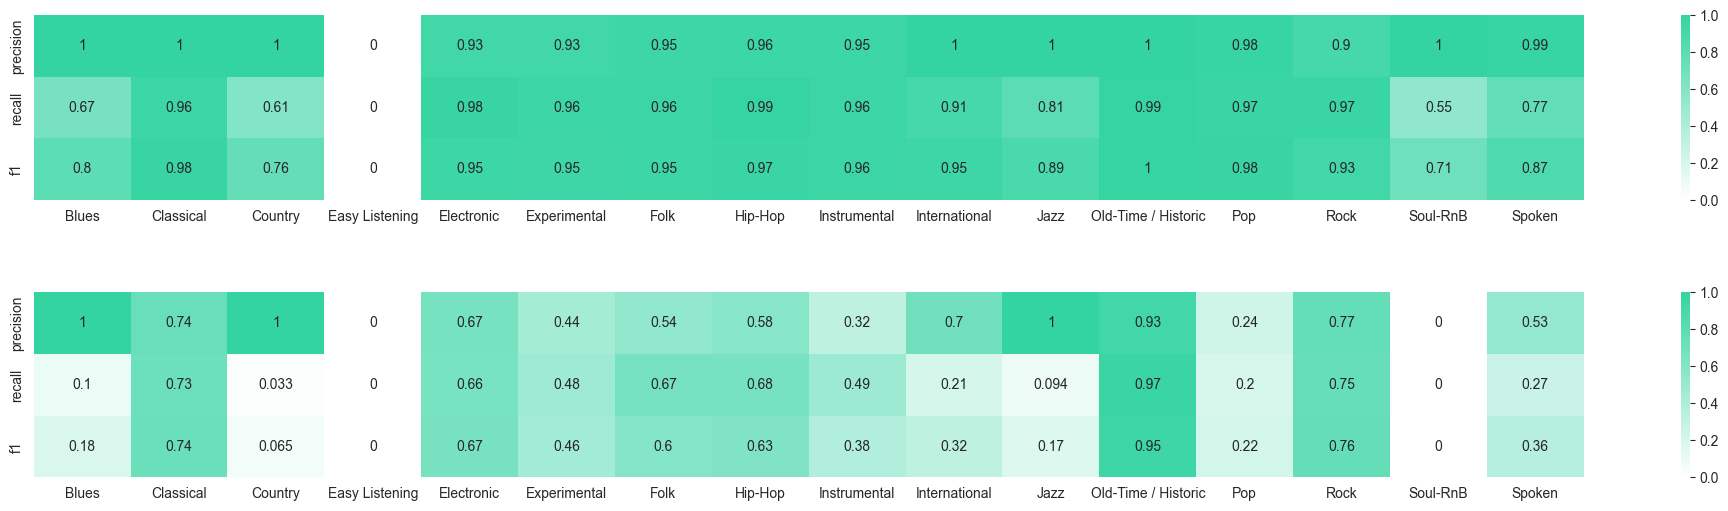

In [41]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
rf_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
rf_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()

The following plot represents the feature importances, and we notice that most important feature (when building the trees), i.e. features that reduce the most uncertainty in the classification process are the spectral features.

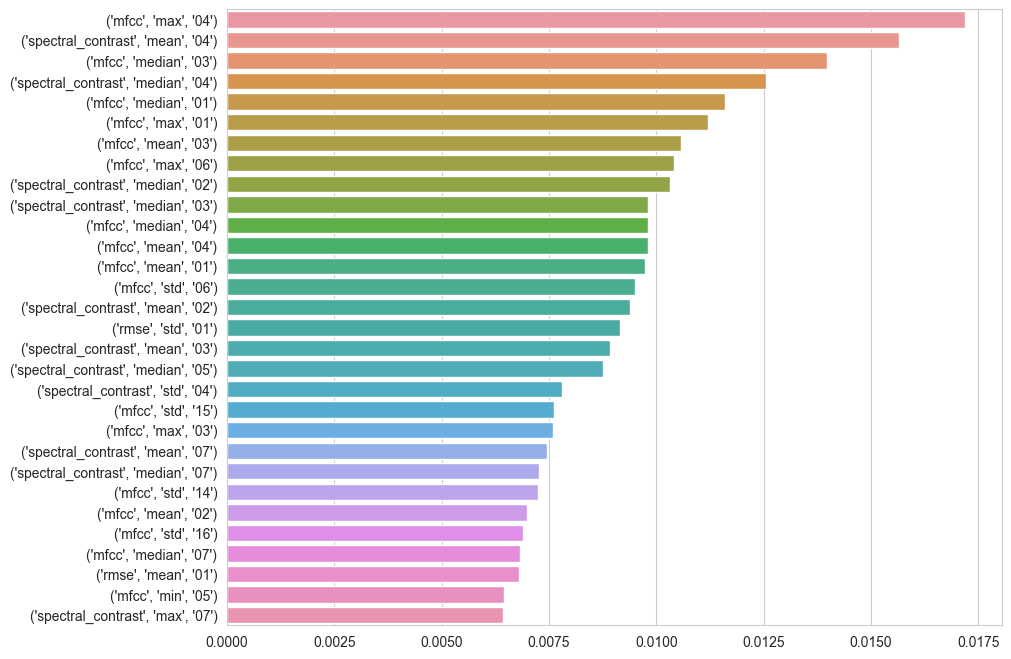

In [50]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
rf_final_classifier.get_clf_evaluation().plot_feature_importances(ax=ax, num_features=30)
plt.show()

Random forests may not be ideal for the task at hand since they only consider one feature at a time, making axis-aligned splits. This approach is unsuitable since the features being analyzed are highly interconnected. Namely, The MFCC features (and others) are interacting features that can distinguish between classes together, but not necessarily in isolation.
In order to overcome this limitation, a more appropriate model would need to be able to examine multiple features simultaneously (such as mean, median, standard deviation of the MFCCs).

# 2. XGBoost

## 2.1 Training

In [11]:
label_encoder = LabelEncoder()
datasets_wrapper.encode_labels(encoder=label_encoder)

In [16]:
xgb_classifiers = [classification_utils.ClassifierFactory.create_instance(
    dataset=dataset, 
    classifier=XGBClassifier(
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        n_jobs=5,
        verbosity=0,
        random_state=23,
    ),
    tree_type_classifier=True
) for dataset in datasets]

In [17]:
xgb_cl_collection = classification_utils.ClassifiersCollection(xgb_classifiers)

In [18]:
xgb_cl_collection.fit_classifiers()

Fitting classifiers...


100%|██████████| 8/8 [42:06<00:00, 315.80s/it]

Done


## 2.2 Initial Results

In [19]:
xgb_evaluation_df = xgb_cl_collection.evaluate_classifiers()

In [20]:
xgb_evaluation_df[[dataset.name for dataset in datasets if 'original' in dataset.name]]

spectral_original                     all_original  \
                                 train       val      test        train   
accuracy                      0.753662  0.632874  0.631904     0.773039   
precision (weighted)          0.762269  0.607279  0.605129     0.780434   
recall (weighted)             0.753662  0.632874  0.631904     0.773039   
f1 (weighted)                 0.739383  0.604064  0.602213     0.760917   

                                         pca_original                      \
                           val      test        train       val      test   
accuracy              0.647476  0.638245     0.728166  0.602420  0.603204   
precision (weighted)  0.635377  0.615503     0.743137  0.575010  0.573827   
recall (weighted)     0.647476  0.638245     0.728166  0.602420  0.603204   
f1 (weighted)         0.620053  0.608542     0.711210  0.567068  0.568527   

                     umap_original                      
                             train       val      test  
accuracy                  0.603931  0.539007  0.543968  
precision (weighted)      0.611709  0.514668  0.518383  
recall (weighted)         0.603931  0.539007  0.543968  
f1 (weighted)             0.580816  0.512824  0.516732

In [21]:
xgb_evaluation_df[[dataset.name for dataset in datasets if 'modified' in dataset.name]]

spectral_modified                     all_modified  \
                                 train       val      test        train   
accuracy                      0.776023  0.594076  0.596362     0.796357   
precision (weighted)          0.779260  0.629194  0.632277     0.799103   
recall (weighted)             0.776023  0.594076  0.596362     0.796357   
f1 (weighted)                 0.775313  0.603182  0.604645     0.795864   

                                         pca_modified                      \
                           val      test        train       val      test   
accuracy              0.609929  0.610045     0.755127  0.574468  0.563824   
precision (weighted)  0.644201  0.641030     0.762329  0.598305  0.587735   
recall (weighted)     0.609929  0.610045     0.755127  0.574468  0.563824   
f1 (weighted)         0.618192  0.616058     0.753838  0.576016  0.565139   

                     umap_modified                      
                             train       val      test  
accuracy                  0.601886  0.499791  0.488737  
precision (weighted)      0.613091  0.544793  0.534414  
recall (weighted)         0.601886  0.499791  0.488737  
f1 (weighted)             0.596082  0.506909  0.495379

Even though the metrics are the best on the all_modified dataset, the feature importances plot indicates that still the most discriminative features are the spectral features. Hence we will fine tune on the spectral_modified dataset (we chose the modified version because it addresses the class imbalance)

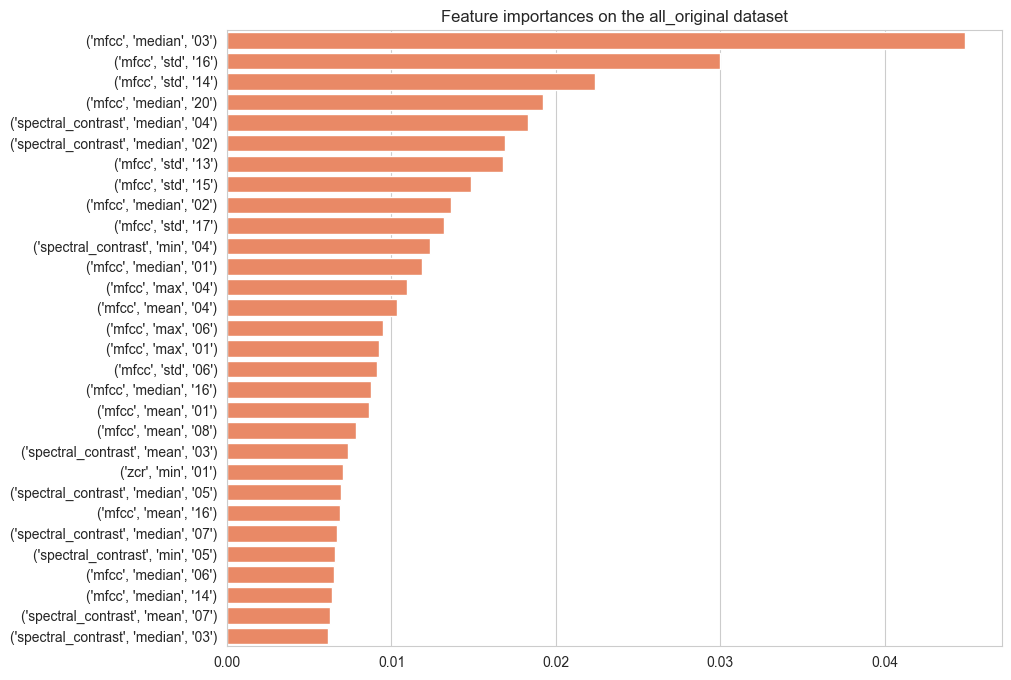

In [25]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb_cl_collection.get_classifier('all_original').get_clf_evaluation().plot_feature_importances(ax=ax, num_features=30)
plt.title('Feature importances on the all_original dataset')
plt.show()

# Hyperparameter tuning

In [ ]:
rf_final_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=rf_dataset,
    classifier=grid_search.best_estimator_,
    tree_type_classifier=True
)

In [28]:
xgb_spectral_modified = datasets_wrapper.get_dataset('spectral_modified')

xgb_classifier = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=500,
    n_jobs=-1,
    verbosity=0,
    random_state=23,
    early_stopping_rounds=5
)

xgb_classifier.fit(
    xgb_spectral_modified.train.X,
    xgb_spectral_modified.train.y,
    eval_set=[(xgb_spectral_modified.val.X, xgb_spectral_modified.val.y)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [37]:
xgb_final_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=xgb_spectral_modified,
    classifier=xgb_classifier,
    tree_type_classifier=True,
    encoder=label_encoder
)

In [38]:
xgb_final_classifier.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.906291,0.626199,0.620891
precision (weighted),0.906839,0.654886,0.649882
recall (weighted),0.906291,0.626199,0.620891
f1 (weighted),0.906194,0.632522,0.626995


Inverse transform on the labels

In [34]:
datasets_wrapper.reverse_encode_labels()

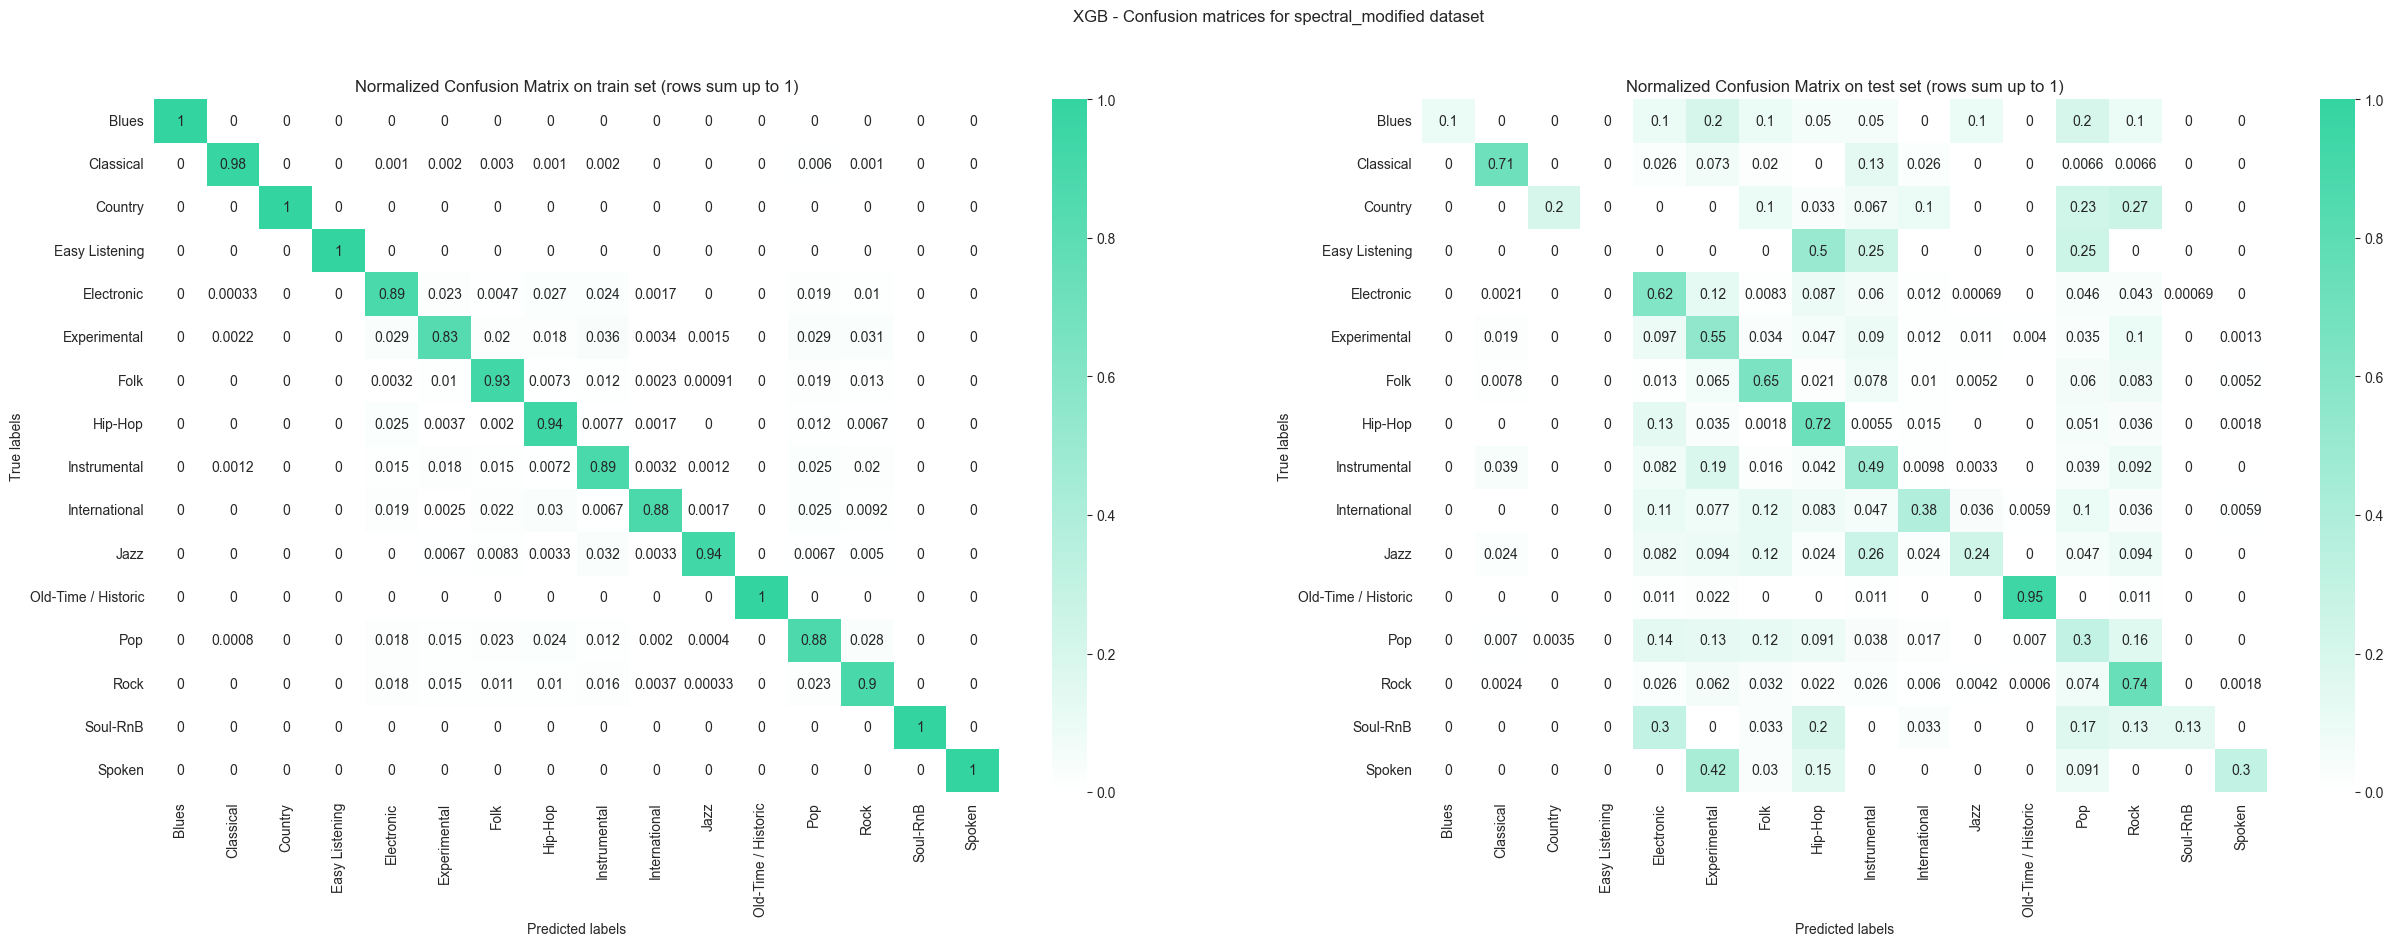

In [39]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
xgb_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
xgb_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('XGB - Confusion matrices for spectral_modified dataset')
plt.show()

Similarly to the random forest, this classifier also overfits to the training set, but fails to generalize well on the test set. Again, none of the Easy Listening tracks are classified as such on the test set, and the classifier seems to perform well in recongizing and correctly classifying Old-Time / Historic as well as Rock songs. Other genres which the classifier correctly predicts are Country, Blues and Soul-RnB, but considering the small recall for these classes, it is probably the case that not many instances were classified as any of these genres.

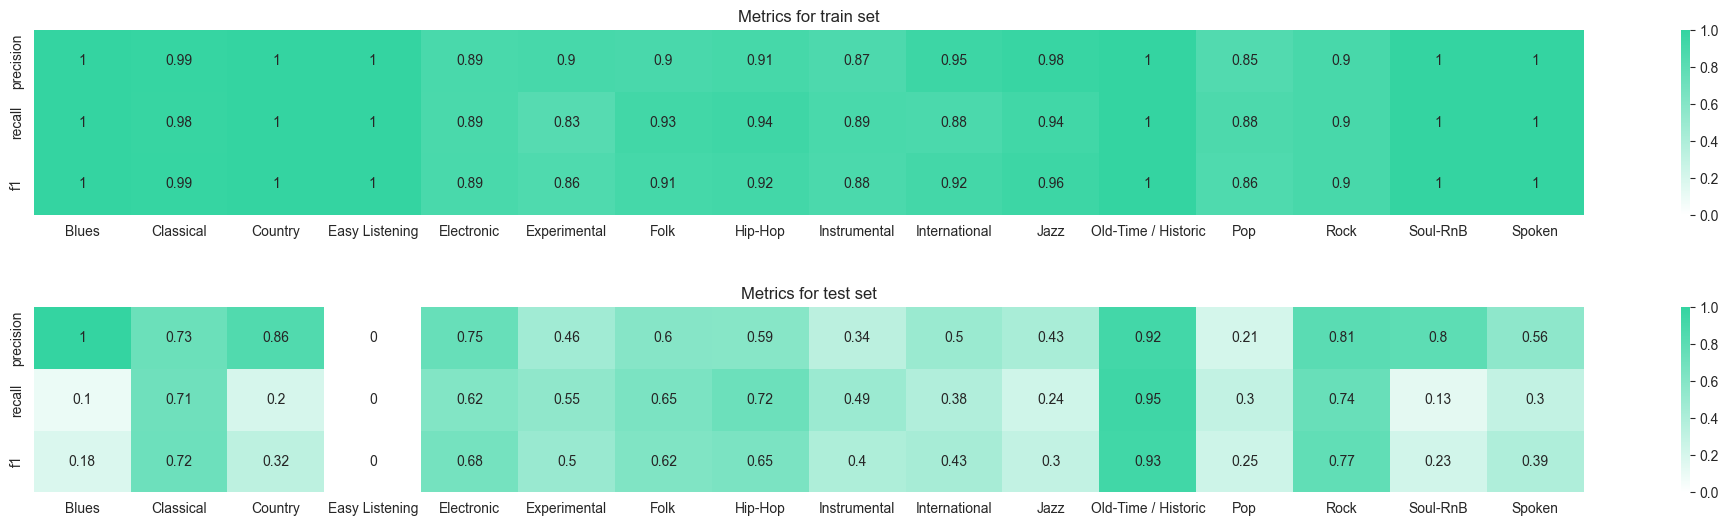

In [40]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
xgb_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
xgb_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()


Similarly to the random forest, the most discriminative features for genre classification seem to be the spectral features (spectral contrast and MFCC).

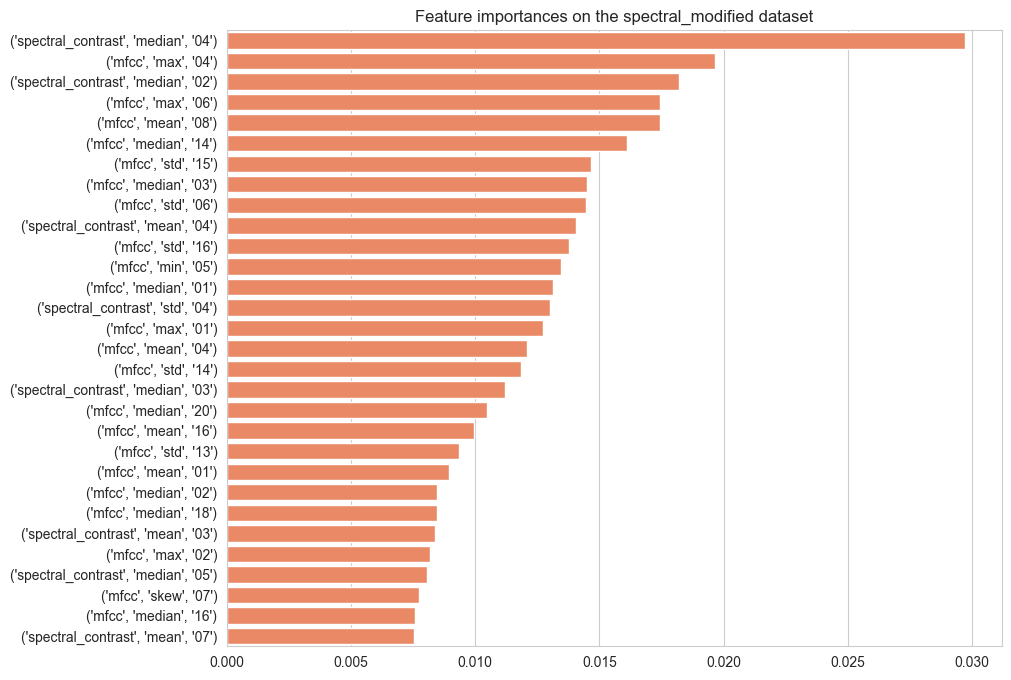

In [42]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb_final_classifier.get_clf_evaluation().plot_feature_importances(ax=ax, num_features=30)
plt.title('Feature importances on the spectral_modified dataset')
plt.show()